The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.0-alpha0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92 kB 827 kB/s 


# The Dataset for Pretraining BERT

BERT 모델을 Pre-train 하려면 
1. masked language modeling과 
2. next sentence prediction 이라는 

두 가지 pretraining task를 쉽게 하기 위해 이상적인 형식으로 데이터 세트를 생성해야 함.

Original BERT 모델은 두 개의 거대한 huge corpora BookCorpus 와 English Wikipedia에서 사전 훈련되어 있어서, 사용되기 어려움 

또한 기존의 BERT 모델은 의약품 분야와 같은 특정 영역의 응용 프로그램에 적합하지 않을 수 있음. 

이런 문제로 맞춤형 데이터 세트에서 BERT를 pretraining하여 사용하는 것이 인기를 끌고 있음.

BERT 사전 훈련의 데모 버전을 구현하기 위해 더 작은 규모인 WikiText-2를 사용

\

WikiText-2 vs  PTB(word2vec Pre-training에 사용)

1. 제거된 원래의 대소문자, 구두점 및 숫자를 유지 

2. 두 배 이상의 크기

In [ ]:
import os
import random
import torch
from torch import nn
from d2l import torch as d2l


WikiText-2 데이터 세트에서 각 행은 Paragraphs을 나타냄 
(구두점과 그 앞의 token 사이에 공백이 삽입되는 space).

두 개 이상의 sentences가 있는 Paragraphs만 유지.

문장을 분할하기 위해 마침표를 단순성을 위한 구분 기호로만 사용.

In [ ]:

d2l.DATA_HUB['wikitext-2'] = (
    'https://s3.amazonaws.com/research.metamind.io/wikitext/'
    'wikitext-2-v1.zip', '3c914d17d80b1459be871a5039ac23e752a53cbe')

#`paragraphs` is a list of lists of lists#
def _read_wiki(data_dir):
    file_name = os.path.join(data_dir, 'wiki.train.tokens')
    with open(file_name, 'r') as f:
        lines = f.readlines()
    # Uppercase letters are converted to lowercase ones
    paragraphs = [line.strip().lower().split(' . ')
                  for line in lines if len(line.split(' . ')) >= 2]
    random.shuffle(paragraphs)
    return paragraphs

In [ ]:
data_dir = d2l.download_extract('wikitext-2', 'wikitext-2')
file_name = os.path.join(data_dir, 'wiki.train.tokens')
with open(file_name, 'r') as f:
  lines = f.readlines()

In [ ]:
print(lines[9])

 As with previous <unk> Chronicles games , Valkyria Chronicles III is a tactical role @-@ playing game where players take control of a military unit and take part in missions against enemy forces . Stories are told through comic book @-@ like panels with animated character portraits , with characters speaking partially through voiced speech bubbles and partially through <unk> text . The player progresses through a series of linear missions , gradually unlocked as maps that can be freely <unk> through and replayed as they are unlocked . The route to each story location on the map varies depending on an individual player 's approach : when one option is selected , the other is sealed off to the player . Outside missions , the player characters rest in a camp , where units can be customized and character growth occurs . Alongside the main story missions are character @-@ specific sub missions relating to different squad members . After the game 's completion , additional episodes are unlo

In [ ]:
paragraphs = _read_wiki(data_dir)

In [ ]:
print(paragraphs[0])

['in contrast to the strong batting line @-@ up , foot suggested that somerset " lacked a seam bowler to compensate for andrew caddick \'s withdrawal "', 'caddick — who made his first @-@ class debut for somerset in 1991 — only played five matches in 2009 , and announced his intention to retire at the end of the season', "he took ten wickets in 2009 , and finished his career as somerset 's sixth highest wicket @-@ taker of all @-@ time", 'this placed the majority of the wicket @-@ taking burden upon <unk> willoughby , the south african fast @-@ medium pace bowler', 'he responded well , and took 54 wickets in the county championship , more than any other bowler in the first division', 'he was aided by seam bowlers david stiff , who returned to the first @-@ class game for the first time since 2006 , and alfonso thomas', 'stiff took 31 wickets , more than <unk> his career first @-@ class wicket total , and thomas took 35 , his highest return in an english domestic season', 'somerset lack

## Defining Helper Functions for Pretraining Tasks


Helper Functions 두개를 정의하는 것으로 시작.

1. next sentence prediction 및 
2. mask language modeling. 

corpus 변환시에 이상적인 형식으로 데이터 세트 변환에 사용 예정

### [**Generating the Next Sentence Prediction Task**]

'*get_next_sentence*'   function은 
binary classification task 를 위한 training example 을 생성


pretraining을 위해 sentence 쌍을 생성할 때 절반은 실제로 "True"라는 label이 있는 연속된 문장입니다. 나머지 절반인 두 번째 문장은 "False"라는 label이 있는 corpus에서 무작위로 샘플링

50:50 비율로 실제 이어지는 두 개의 문장과 랜덤으로 이어붙인 두 개의 문장

In [ ]:
def _get_next_sentence(sentence, next_sentence, paragraphs):
    if random.random() < 0.5: #0.0이상 1 미만의 실수를 반환
        is_next = True
    else:
        # `paragraphs` is a list of lists of lists
        next_sentence = random.choice(random.choice(paragraphs))
        is_next = False
    return sentence, next_sentence, is_next


다음 함수는 *_get_next_sents* 함수를 호출하여 input paragraph에서 다음 문장 예측을 위한  training examples를 생성. 

paragraph는 sentences list이고, 각 sentence는 tokens list 

'*max_len*'은 pretraining 중 BERT input sequence의 최대 길이를 지정.


In [ ]:
print(random.random())

0.5439209102836339


In [ ]:
def _get_nsp_data_from_paragraph(paragraph, paragraphs, vocab, max_len):
    nsp_data_from_paragraph = []
    for i in range(len(paragraph) - 1):
        tokens_a, tokens_b, is_next = _get_next_sentence(
            paragraph[i], paragraph[i + 1], paragraphs)
        # Consider 1 '<cls>' token and 2 '<sep>' tokens
        # [CLS]란 벡터는 초기 입력일 땐 단순히 임베딩 층을 지난 임베딩 벡터였지만, 
        # BERT를 지나면 [CLS], I, love, you 라는 모든 단어 벡터들을 참고한 문맥 정보를 가진 벡터
        if len(tokens_a) + len(tokens_b) + 3 > max_len:
            continue
        tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)#segement embedding 
        nsp_data_from_paragraph.append((tokens, segments, is_next))
    return nsp_data_from_paragraph


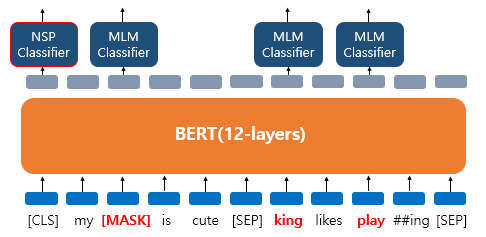

첫 번째 문장의 끝에 [SEP] 토큰을 넣고, 두 번째 문장이 끝나면 역시 [SEP] 토큰을 붙임. 그리고 이 두 문장이 실제 이어지는 문장인지 아닌지를 [CLS] 토큰 위치의 출력층에서 이진 분류 문제로 해결


- 위의 그림처럼 next sentence prediction 및
mask language modeling는 따로 학습하는 것이 아니라 loss를 합하여 학습이 동시에 이루어짐


- BERT가 언어 모델 외에도 다음 문장 예측이라는 태스크를 학습하는 이유는 QA(Question Answering)나 NLI(Natural Language Inference)와 같이 두 문장의 관계를 이해하는 것이 중요한 태스크들도 있기 때문

In [ ]:
#
#def get_tokens_and_segments(tokens_a, tokens_b=None):
#    """Get tokens of the BERT input sequence and their segment IDs."""
#    tokens = ['<cls>'] + tokens_a + ['<sep>']
#    # 0 and 1 are marking segment A and B, respectively
#    segments = [0] * (len(tokens_a) + 2)
#    if tokens_b is not None:
#        tokens += tokens_b + ['<sep>']
#        segments += [1] * (len(tokens_b) + 1)
#    return tokens, segments


WordPiece Embedding
- 실질적인 입력이 되는 워드 임베딩
- 임베딩 벡터의 종류는 단어 집합의 크기

Segment Embedding
- 두 개의 문장을 구분하기 위한 임베딩
- 임베딩 벡터의 종류는 문장의 최대 개수인 2개

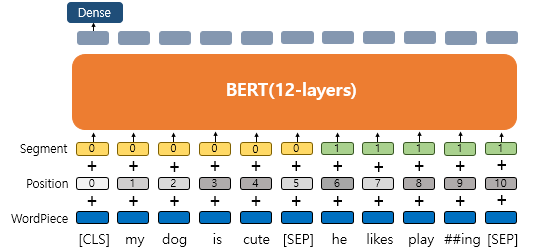

### [**Generating the Masked Language Modeling Task**]

BERT는 사전 훈련을 위해 입력 텍스트의 15% 단어를 랜덤으로 마스킹합니다. 이후 신경망이 가려진 단어들을 예측하도록 합니다. 쉽게 말해 빈칸 뚫고 맞추기 학습.

- BERT input sequence 로 부터 masked language modeling tasks를 위한 example을 생성하기 위해 _replace_mlm_tokens 함수를 정의. 


- input에서 'tokens'는 BERT input sequence 를 나타내는 토큰 목록.

- 'candidate_pred_positions'는 특수 토큰을 제외한 BERT 입력 시퀀스의 토큰 인덱스 목록. 
(masked language modeling task에서 특수 토큰은 예측되지 않음)


- num_mlm_preds는 예측의 수  (예측할 15% 랜덤 토큰을 불러옴)


더 정확히는 전부 [MASK]로 변경하지 않고 랜덤으로 선택된 15% 단어들은 다시 다음과 같은 비율로 규칙이 적용됩니다.

1. 80% 단어들은 [MASK]로 변경

  예) The man went to the store -> The man went to the [MASK]

2. 10% 단어들은 램덤으로 단어 변경

  예) The man went to the store -> The man went to the dog

3. 10% 단어들은 동일하게 유지

  예) The man went to the store -> The man went to the store

결국, 이 함수는 
입력 토큰, 예측이 이루어지는 토큰 인덱스 및 이러한 예측에 대한 레이블을 반환.

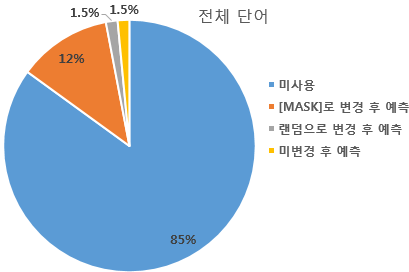

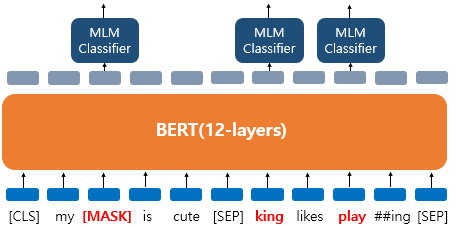

'My dog is cute. he likes playing' 이 원래 문장일 때

위의 경우에는 BERT가 랜덤 단어 'king'으로 변경된 토큰에 대해서도, 변경되지 않은 단어 'play'에 대해서도 원래 단어가 무엇인지 추가로 예측해야 함

In [ ]:
def _replace_mlm_tokens(tokens, candidate_pred_positions, num_mlm_preds,
                        vocab):
    
    # 그 중 일부를 '마스크'또는 임의의 토큰으로 바꿈.
    mlm_input_tokens = [token for token in tokens] # 모델 Input을 위한 새로운 토큰 카피를 만들고
    pred_positions_and_labels = []
    # Shuffle for getting 15% random tokens for prediction in the masked
    # language modeling task
    random.shuffle(candidate_pred_positions) # 마스킹된 상태에서 예측을 위해 15% 랜덤 토큰을 얻기 위한 셔플
    for mlm_pred_position in candidate_pred_positions:
        if len(pred_positions_and_labels) >= num_mlm_preds: #num_mlm_preds = max(1, round(len(tokens) * 0.15))
            break
        masked_token = None
        # 80% of the time: replace the word with the '<mask>' token
        if random.random() < 0.8:
            masked_token = '<mask>'
        else:
            # 10% of the time: keep the word unchanged
            if random.random() < 0.5:
                masked_token = tokens[mlm_pred_position]
            # 10% of the time: replace the word with a random word
            else:
                masked_token = random.choice(vocab.idx_to_token)
        mlm_input_tokens[mlm_pred_position] = masked_token
        pred_positions_and_labels.append(
            (mlm_pred_position, tokens[mlm_pred_position]))
    return mlm_input_tokens, pred_positions_and_labels



앞에서 언급한 _replace_mlm_tokens 함수를 호출함으로써, 다음 함수는 BERT 입력 시퀀스(토큰)를 입력으로 가져와서 입력 토큰의 인덱스(제15.8.5.1절에서 설명한 대로 가능한 토큰 교체 후), 예측이 이루어지는 토큰 인덱스, 그리고 이러한 예측에 대한 레이블 인덱스를 반환.

In [ ]:

def _get_mlm_data_from_tokens(tokens, vocab):
    candidate_pred_positions = []
    # `tokens` is a list of strings
    for i, token in enumerate(tokens):
        # Special tokens are not predicted in the masked language modeling
        # task
        if token in ['<cls>', '<sep>']:
            continue
        candidate_pred_positions.append(i)
    # 15% of random tokens are predicted in the masked language modeling task
    num_mlm_preds = max(1, round(len(tokens) * 0.15))
    mlm_input_tokens, pred_positions_and_labels = _replace_mlm_tokens(
        tokens, candidate_pred_positions, num_mlm_preds, vocab)
    pred_positions_and_labels = sorted(pred_positions_and_labels,
                                       key=lambda x: x[0]) #0번 즉 position 기준으로 오름차순
    pred_positions = [v[0] for v in pred_positions_and_labels]
    mlm_pred_labels = [v[1] for v in pred_positions_and_labels]
    return vocab[mlm_input_tokens], pred_positions, vocab[mlm_pred_labels]

## Transforming Text into the Pretraining Dataset



이제 사전 교육 BERT를 위해 'Dataset' class customize 준비가 거의 되었음. 

그 전에 입력에 특수 'pad' 토큰을 추가하기 위해 helper function _pad_bert_inputs를 정의해야 함. 

'example'에는 두 pretraining task에 대한 helper fuction _get_nsp_data_from 과 _get_mlm_data_from_tokens 에서의 출력이 포함되어 있음.

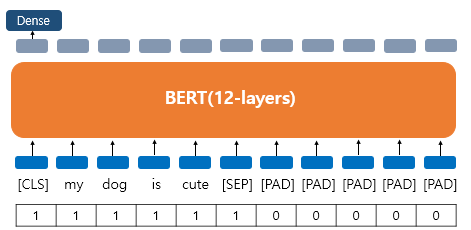

**BERT를 실제로 실습할 때 어텐션 마스크라는 시퀀스 입력이 추가로 필요함.**


- 어텐션 마스크는 BERT가 어텐션 연산을 할 때, 불필요하게 패딩 토큰에 대해서 어텐션을 하지 않도록 실제 단어와 패딩 토큰을 구분할 수 있도록 알려주는 입력. 

- 0과 1 두 가지 값을 가지는데, 숫자 1은 해당 토큰은 실제 단어이므로 마스킹을 하지 않는다라는 의미이고, 숫자 0은 해당 토큰은 패딩 토큰이므로 마스킹을 한다는 의미

In [ ]:
def _pad_bert_inputs(examples, max_len, vocab):
    max_num_mlm_preds = round(max_len * 0.15)
    all_token_ids, all_segments, valid_lens,  = [], [], []
    all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
    nsp_labels = []
    for (token_ids, pred_positions, mlm_pred_label_ids, segments,
         is_next) in examples:
        all_token_ids.append(torch.tensor(token_ids + [vocab['<pad>']] * (
            max_len - len(token_ids)), dtype=torch.long))
        all_segments.append(torch.tensor(segments + [0] * (
            max_len - len(segments)), dtype=torch.long))
        # `valid_lens` 는'<pad>' tokens 은 제외한 길이
        valid_lens.append(torch.tensor(len(token_ids), dtype=torch.float32))
        all_pred_positions.append(torch.tensor(pred_positions + [0] * (
            max_num_mlm_preds - len(pred_positions)), dtype=torch.long))
        # Predictions of padded tokens will be filtered out in the loss via
        # multiplication of 0 weights
        all_mlm_weights.append(
            torch.tensor([1.0] * len(mlm_pred_label_ids) + [0.0] * (
                max_num_mlm_preds - len(pred_positions)),
                dtype=torch.float32))
        all_mlm_labels.append(torch.tensor(mlm_pred_label_ids + [0] * (
            max_num_mlm_preds - len(mlm_pred_label_ids)), dtype=torch.long))
        nsp_labels.append(torch.tensor(is_next, dtype=torch.long))
    return (all_token_ids, all_segments, valid_lens, all_pred_positions,
            all_mlm_weights, all_mlm_labels, nsp_labels)


앞서 만든 두 가지 Pretrain model task 의 example을 생성하기 위한 기능들과과 입력을 함께 패딩하기 위한 기능을 종합하여 _WikiTextDataset 클래스를 정의. 
 
쉽게 토큰화를 위해 여기서는 d2l.tokenize 함수를 사용합니다. 5번 미만의 자주 나타나지 않는 토큰은 필터링됩니다.

++

BERT는 단어보다 더 작은 단위로 쪼개는 서브워드 토크나이저(subword tokenizer)를 사용 서브워드 토크나이저는 기본적으로 자주 등장하는 단어는 그대로 단어 집합에 추가하지만, 자주 등장하지 않는 단어는 더 작은 단위인 서브워드로 분리되어 서브워드들이 단어 집합에 추가

준비물: 이미 훈련 데이터로부터 만들어진 단어 집합

1. 토큰이 단어 집합에 존재 => 해당 토큰을 분리하지 않음
2. 토큰이 단어 집합에 존재하지 않음 => 해당 토큰을 서브워드로 분리
                                
해당 토큰의 첫 번째 서브워드를 제외한 나머지 서브워드들앞에                                           '##'를 붙인 것을 토큰으로 함


embeddings라는 단어가 입력으로 들어왔을 때 BERT는 단어 집합에 해당 단어가 존재하지 않을 때
서브워드 토크나이저가 아닌 토크나이저라면 여기서 OOV(out of vocabulary) 문제가 발생하지만, 서브워드 토크나이저의 경우 해당 단어를 더 쪼개려고 시도합니다. 만약 BERT의 단어 집합에 em, ##bed, ##ding, #s라는 서브워드들이 존재한다면 embeddings는 em, ##bed, ##ding, #s로 분리됩니다. 여기서 ##은 서브워드들이 단어 중간부터 등장하는 것임을 알려주기 위한 기호

In [ ]:

class _WikiTextDataset(torch.utils.data.Dataset):
    def __init__(self, paragraphs, max_len):
        # Input `paragraphs[i]` is a list of sentence strings representing a
        # paragraph; while output `paragraphs[i]` is a list of sentences
        # representing a paragraph, where each sentence is a list of tokens
        paragraphs = [d2l.tokenize(
            paragraph, token='word') for paragraph in paragraphs] ##토크나이징 간단하게 실행
        sentences = [sentence for paragraph in paragraphs
                     for sentence in paragraph]
        self.vocab = d2l.Vocab(sentences, min_freq=5, reserved_tokens=[
            '<pad>', '<mask>', '<cls>', '<sep>'])
        # Get data for the next sentence prediction task
        examples = []
        for paragraph in paragraphs:
            examples.extend(_get_nsp_data_from_paragraph(
                paragraph, paragraphs, self.vocab, max_len))
        # Get data for the masked language model task
        examples = [(_get_mlm_data_from_tokens(tokens, self.vocab)
                      + (segments, is_next))
                     for tokens, segments, is_next in examples]
        # Pad inputs
        (self.all_token_ids, self.all_segments, self.valid_lens,
         self.all_pred_positions, self.all_mlm_weights,
         self.all_mlm_labels, self.nsp_labels) = _pad_bert_inputs(
            examples, max_len, self.vocab)

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx], self.all_pred_positions[idx],
                self.all_mlm_weights[idx], self.all_mlm_labels[idx],
                self.nsp_labels[idx])

    def __len__(self):
        return len(self.all_token_ids)

By using the `_read_wiki` function and the `_WikiTextDataset` class,
we define the following `load_data_wiki` to [**download and WikiText-2 dataset
and generate pretraining examples**] from it.


_read_wiki 함수와 _WikiTextDataset 클래스를 사용하여 다운로드할 load_data_wiki와 WikiText-2 데이터 세트를 정의하고 사전 교육 예제를 생성합니다.

In [ ]:
def load_data_wiki(batch_size, max_len):
    """Load the WikiText-2 dataset."""
    num_workers = d2l.get_dataloader_workers()
    data_dir = d2l.download_extract('wikitext-2', 'wikitext-2')
    paragraphs = _read_wiki(data_dir)
    train_set = _WikiTextDataset(paragraphs, max_len) #위에서 만든 것들로 최종적으로 train set을 생성
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                        shuffle=True, num_workers=num_workers)
    return train_iter, train_set.vocab

Setting the batch size to 512 and the maximum length of a BERT input sequence to be 64,
we [**print out the shapes of a minibatch of BERT pretraining examples**].
Note that in each BERT input sequence,
$10$ ($64 \times 0.15$) positions are predicted for the masked language modeling task.


배치 크기를 512로 설정하고 BERT 입력 시퀀스의 최대 길이를 64로 설정
하면 BERT example의 미니 배치 모양이 출력됨. 

각 BERT 입력 시퀀스에서 마스킹된 언어 모델링 작업에 대해 10개(64x0.15)의 위치가 예측.


In [ ]:
batch_size, max_len = 512, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)

for (tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X,
     mlm_Y, nsp_y) in train_iter:
    print(tokens_X.shape, segments_X.shape, valid_lens_x.shape,
          pred_positions_X.shape, mlm_weights_X.shape, mlm_Y.shape,
          nsp_y.shape)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([512, 64]) torch.Size([512, 64]) torch.Size([512]) torch.Size([512, 10]) torch.Size([512, 10]) torch.Size([512, 10]) torch.Size([512])


마지막으로 어휘의 크기를 살펴보자. 빈도 수가 작은 토큰을 필터링한 후에도 PTB 데이터 세트보다 두 배 이상 크다.

In [ ]:
len(vocab)

20256

## Summary



- PTB 데이터 세트와 비교했을 때, 위키텍스트-2 날짜 집합은 원래 문장 부호, 대/소문자 및 숫자를 유지하며 두 배 이상 크다. 

- WikiText-2 말뭉치의 문장 쌍에서 생성된 사전 훈련(마스크 언어 모델링 및 다음 문장 예측) 예제에 임의로 액세스할 수 있다.

## Exercises

1. For simplicity, the period is used as the only delimiter for splitting sentences. Try other sentence splitting techniques, such as the spaCy and NLTK. Take NLTK as an example. You need to install NLTK first: `pip install nltk`. In the code, first `import nltk`. Then, download the Punkt sentence tokenizer: `nltk.download('punkt')`. To split sentences such as `sentences = 'This is great ! Why not ?'`, invoking `nltk.tokenize.sent_tokenize(sentences)` will return a list of two sentence strings: `['This is great !', 'Why not ?']`.
1. What is the vocabulary size if we do not filter out any infrequent token?


# 15.10. Pretraining BERT


15.8에서 구현된 BERT 모델과 섹션 
15.9의 WikiText-2 데이터 세트에서 생성된 example을 사용하여
이 섹션에서 BERT를 Pretraining.


In [ ]:
batch_size, max_len = 512, 64
train_iter, vocab = d2l.load_data_wiki(batch_size, max_len) # 방금한 것인데 섹션 바뀌어서 한번 더 언급..

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


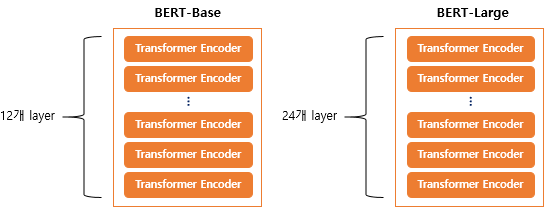

##15.10.1. Pretraining BERT

original bert 모델은 위와 같이 구성됨.
- L = 인코더 층 개수
- D = 
d
model
 크기(인코더와 디코더 입력/출력의 크기 = 임베딩 벡터 차원)
- A = 셀프 어텐션 헤드 개수
- BERT-Base: L=12, D=768, A=12 -> 110M개의 파라미터
- BASE-Large: L=24, D=1024, A=16 -> 340M개의 파라미터

이 장에서는 간단하게 보기위해 small BERT를 아래의 파라미터로 정의
- 2 layers 
- 128 hidden units
- 2 self-attention heads.

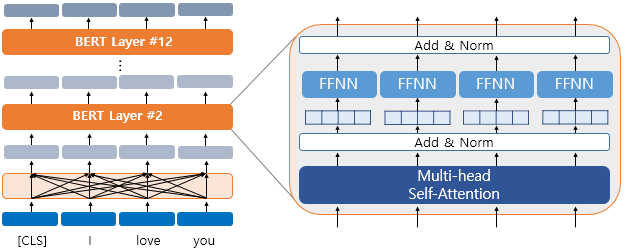

++

트랜스포머의 인코더 부분을 생각하면 쉬움


- Self attention은 문장 간의 관계가 아니라 문장 자신 내에서 단어들의 관계를 보는 것 (ex. 문장에서 it이 무엇을 의미하는지)

- Multi-Head Attention의 역할은 1문장을 여러 head로 Self-Attention 시킴

- 쉽게 말하면 동일한 문장도 8명(8 heads)이 각각의 관점에서 보고 추후에 합치는 과정

그림은 입력 단어 수는 2개, 밸류의 차원수는 3, 헤드는 8개인 멀티-헤드 어텐션을 나타낸 그림입니다. 개별 헤드의 셀프 어텐션 수행 결과는 ‘입력 단어 수  ×  밸류 차원수’, 즉  2×3  크기를 갖는 행렬입니다. 8개 헤드의 셀프 어텐션 수행 결과를 다음 그림의 ①처럼 이어 붙이면  2×24 의 행렬이 됨.

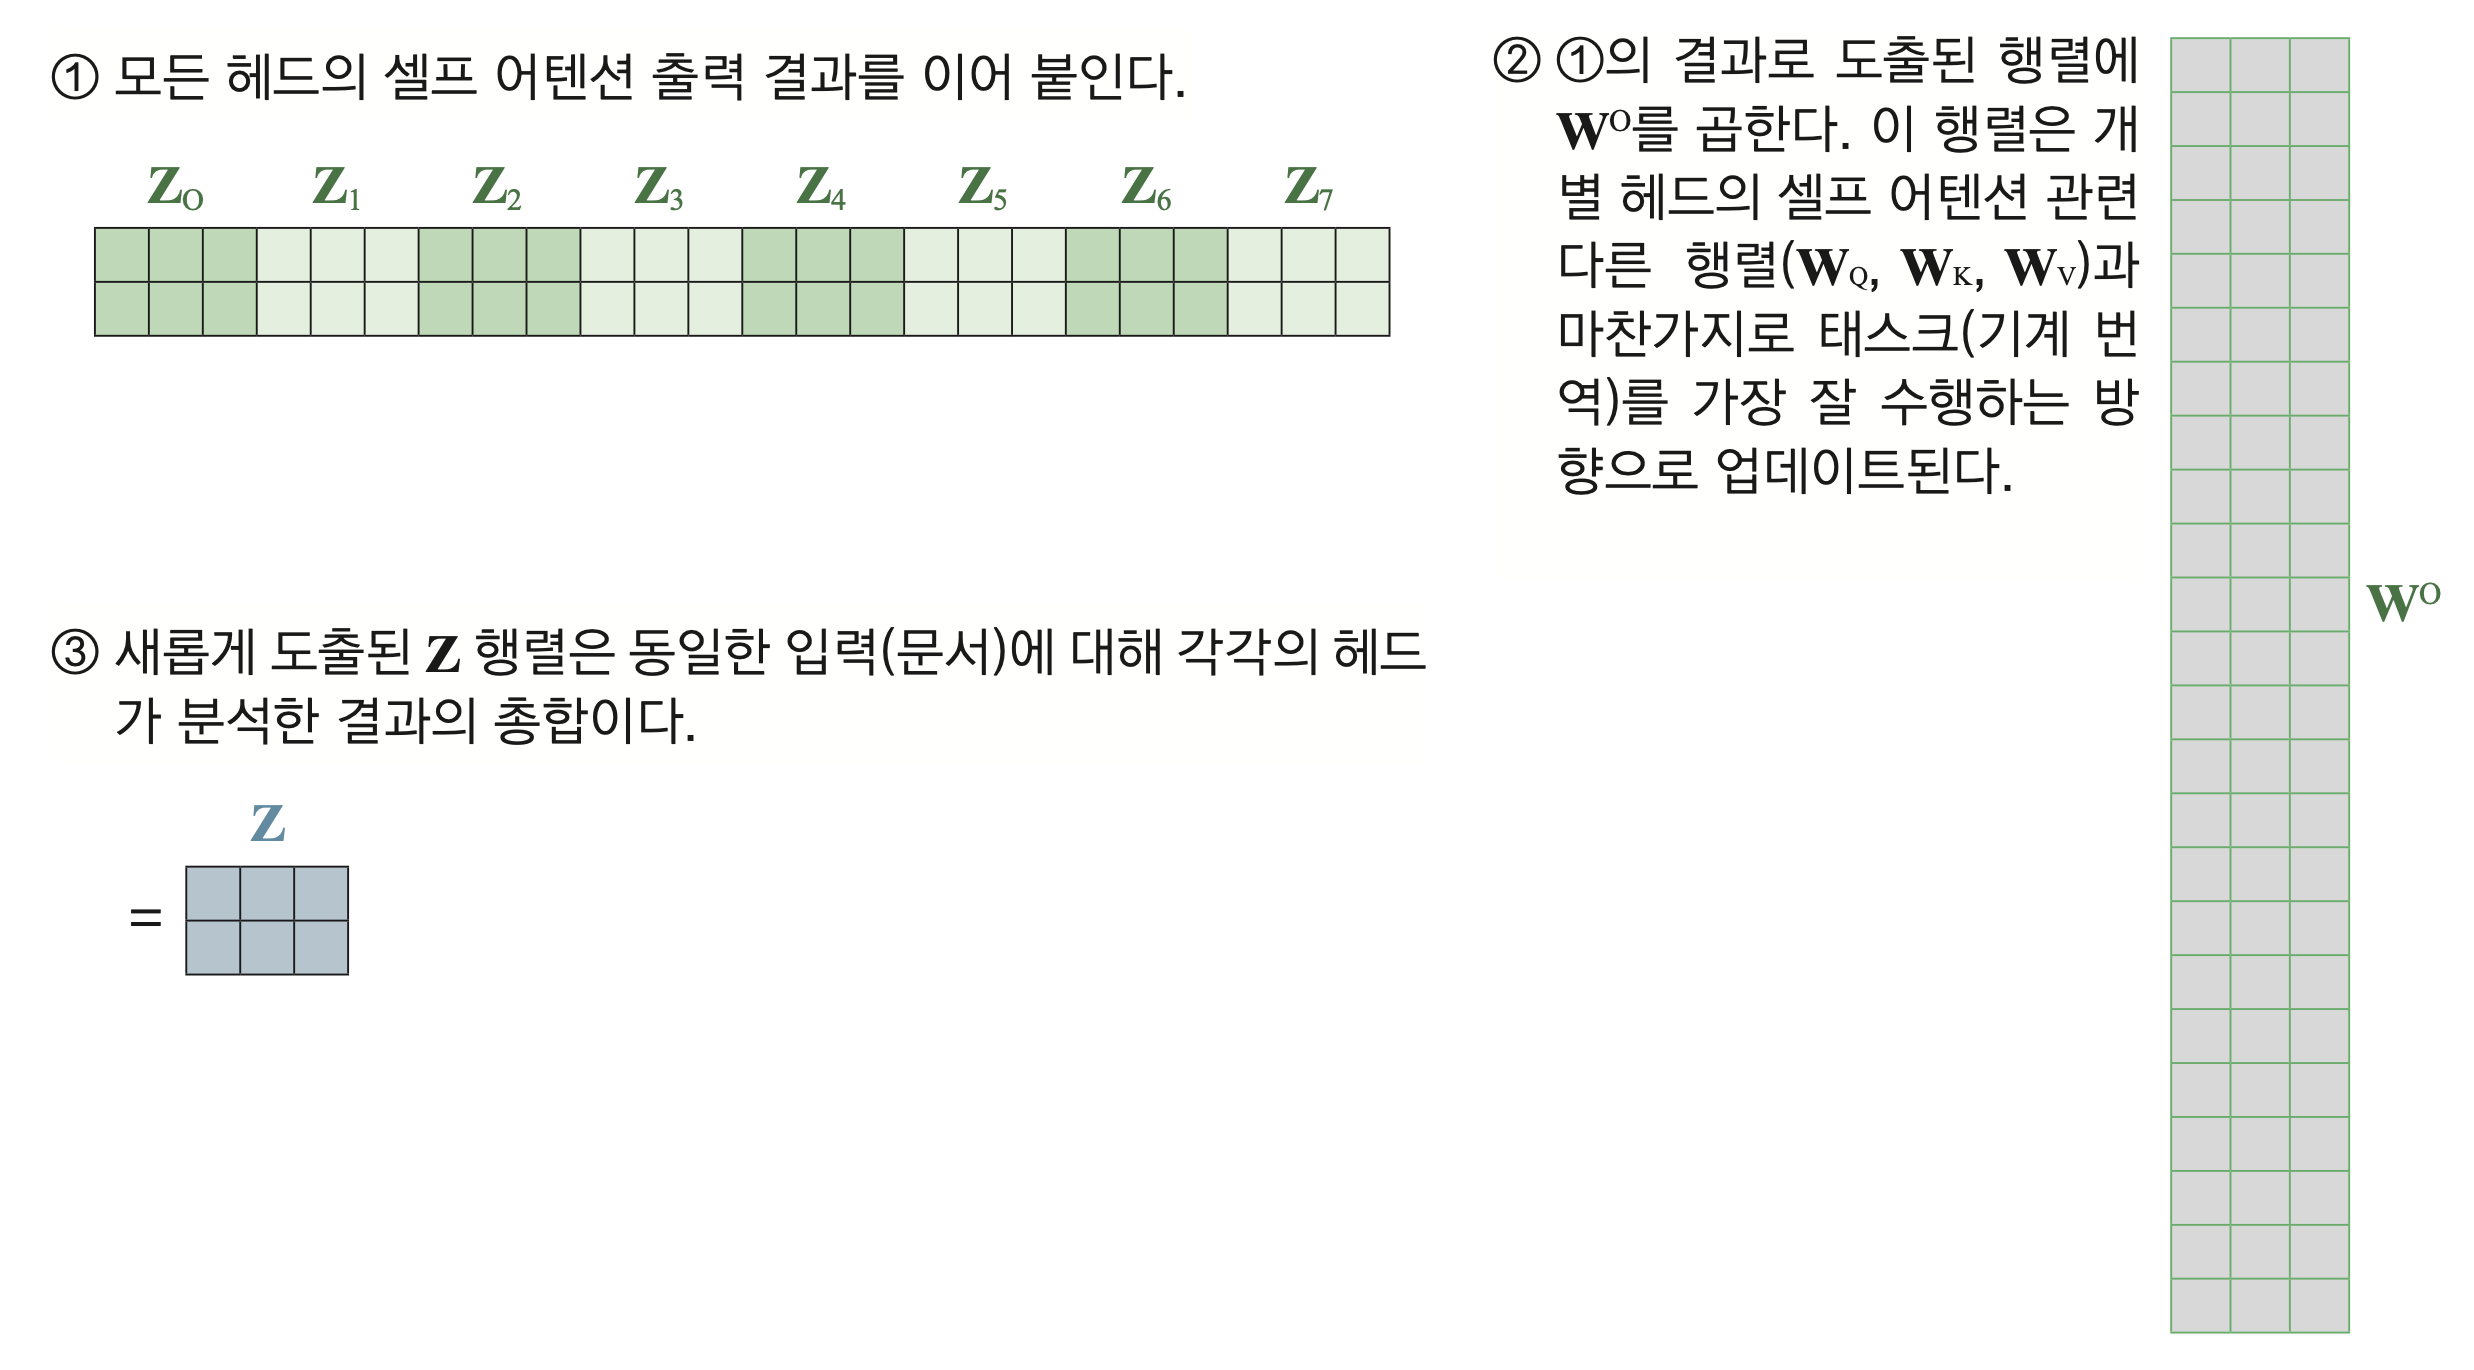

Q : 현재 처리 하고 있는 정보 (hidden state)

K : 각 정보들의 label

V : label별 특성 정보

즉 특정 단어(Query)와 나머지 단어들(Key들)간 각각의 유사도 점수(softmax를 취한 이후)만큼, 각각의 Value를 참조하여 더한(가중합) 한 벡터가 Attention 벡터

In [ ]:
net = d2l.BERTModel(len(vocab), num_hiddens=128,
                    ffn_num_hiddens=256, num_heads=2, num_blks=2, dropout=0.2)
devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
class MaskLM(nn.Module):
    """The masked language model task of BERT.
    Defined in :numref:`subsec_bert_input_rep`"""
    def __init__(self, vocab_size, num_hiddens, **kwargs):
        super(MaskLM, self).__init__(**kwargs)
        self.mlp = nn.Sequential(nn.LazyLinear(num_hiddens),
                                 nn.ReLU(),
                                 nn.LayerNorm(num_hiddens),
                                 nn.LazyLinear(vocab_size))

    def forward(self, X, pred_positions):
        num_pred_positions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        # Suppose that `batch_size` = 2, `num_pred_positions` = 3, then
        # `batch_idx` is `torch.tensor([0, 0, 0, 1, 1, 1])`
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
        masked_X = X[batch_idx, pred_positions]
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        mlm_Y_hat = self.mlp(masked_X)
        return mlm_Y_hat

class NextSentencePred(nn.Module):
    """The next sentence prediction task of BERT.
    Defined in :numref:`subsec_mlm`"""
    def __init__(self, **kwargs):
        super(NextSentencePred, self).__init__(**kwargs)
        self.output = nn.LazyLinear(2)

    def forward(self, X):
        # `X` shape: (batch size, `num_hiddens`)
        return self.output(X)

class BERTModel(nn.Module):
    """The BERT model.
    Defined in :numref:`subsec_nsp`"""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, max_len=1000):
        super(BERTModel, self).__init__()
        self.encoder = BERTEncoder(vocab_size, num_hiddens, ffn_num_hiddens,
                                   num_heads, num_blks, dropout,
                                   max_len=max_len)
        self.hidden = nn.Sequential(nn.LazyLinear(num_hiddens),
                                    nn.Tanh())
        self.mlm = MaskLM(vocab_size, num_hiddens)
        self.nsp = NextSentencePred()

    def forward(self, tokens, segments, valid_lens=None, pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        # The hidden layer of the MLP classifier for next sentence prediction.
        # 0 is the index of the '<cls>' token
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))
        return encoded_X, mlm_Y_hat, nsp_Y_hat

In [ ]:
print(net)

BERTModel(
  (encoder): BERTEncoder(
    (token_embedding): Embedding(20256, 128)
    (segment_embedding): Embedding(2, 128)
    (blks): Sequential(
      (0): TransformerEncoderBlock(
        (attention): MultiHeadAttention(
          (attention): DotProductAttention(
            (dropout): Dropout(p=0.2, inplace=False)
          )
          (W_q): LazyLinear(in_features=0, out_features=128, bias=True)
          (W_k): LazyLinear(in_features=0, out_features=128, bias=True)
          (W_v): LazyLinear(in_features=0, out_features=128, bias=True)
          (W_o): LazyLinear(in_features=0, out_features=128, bias=True)
        )
        (addnorm1): AddNorm(
          (dropout): Dropout(p=0.2, inplace=False)
          (ln): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (ffn): PositionWiseFFN(
          (dense1): LazyLinear(in_features=0, out_features=256, bias=True)
          (relu): ReLU()
          (dense2): LazyLinear(in_features=0, out_features=128, bias=True)


**트레이닝 루프를 정의하기 전에 helper 함수 _get_batch_loss_bert를 정의**


Training Example이 주어지면 , 앞서 언급했던것처럼 이 함수로 next sentence prediction 및 mask language modeling는 따로 학습하는 것이 아니라 loss를 합하여 학습이 동시에 이루어짐. 

최종 loss는 두 loss의 합.

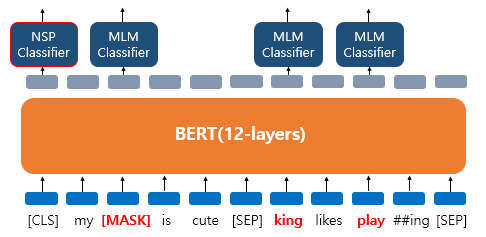

In [ ]:
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    # Forward pass
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape(-1),
                                  pred_positions_X)
    # Compute masked language model loss
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) *\
    mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # Compute next sentence prediction loss
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

BERT 훈련은 매우 오래 걸릴 수 있음. 

train_ch13 함수에서처럼 훈련을 위한 에폭의 수를 지정하는 대신 (제14.1절 참조) 

1 배치로부터 loss를 계산한 후 Weight와 Bias를 1회 업데이트하는 것을 1 Step

num_step으로 반복 단계의 수를 지정. 

In [ ]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    net(*next(iter(train_iter))[:4])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.Adam(net.parameters(), lr=0.01)
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # Sum of masked language modeling losses, sum of next sentence prediction
    # losses, no. of sentence pairs, count
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X,\
            mlm_weights_X, mlm_Y, nsp_y in train_iter:
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            trainer.zero_grad()
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')

MLM loss 5.331, NSP loss 0.769
3753.9 sentence pairs/sec on [device(type='cuda', index=0)]


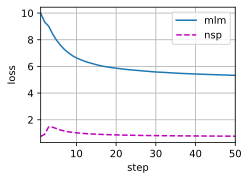

In [ ]:
train_bert(train_iter, net, loss, len(vocab), devices, 50)

##15.10.2. Representing Text with BERT

pretraining 된 BERT를 사용하여 single text, text pairs, 또는 어떤 token이든 표현할 수 있음.

In [ ]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

“a crane is flying” 이라는 문장을 생각해 보자. 


[cls] (분류에 사용됨) 
[sep] (분리에 사용됨)
BERT input sequence 의 길이는 6. 
- Tokens: [ '[cls]', 'a', 'crane', 'is', 'flying', '[sep] ]'

0은 [cls] 토큰의 인덱스이므로, encoded_text[:, 0, :]는

전체 input의 BERT 표현.

polysemy(의미가 여러 개인) 토큰 {crane}을 평가하기 위해 토큰의 처음 3개의 elements도 출력.

In [ ]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
# Tokens: '<cls>', 'a', 'crane', 'is', 'flying', '<sep>'
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

(torch.Size([1, 6, 128]),
 torch.Size([1, 128]),
 tensor([-0.7318,  0.0660,  0.2292], device='cuda:0', grad_fn=<SliceBackward0>))

"a crane driver came"과 "he just left"라는 문장 쌍을 보자.

마찬가지로 encoded_pair[:, 0, :]는 전체 문장 쌍의 인코딩된 결과. 

다의성을 가진 토큰 "crane"의 처음 3가지 elements는 문맥(context)이 다를 때와는 다르다는 점에 유의. 이것은 BERT 표현이 문맥에 민감하다(context-sensitive)는 것을 지원한다.

In [ ]:
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# Tokens: '<cls>', 'a', 'crane', 'driver', 'came', '<sep>', 'he', 'just',
# 'left', '<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

(torch.Size([1, 10, 128]),
 torch.Size([1, 128]),
 tensor([-0.7492,  1.8799,  0.1676], device='cuda:0', grad_fn=<SliceBackward0>))